# Windy Gridworld
Shantanu Laghate, Nov 2024

We're going to make a standard Gridworld environment with a State state, and a Goal state, except with a Northward "wind" through the middle of the grid. The agent starts in the Start state, and to begin with has 4 actions: `{NORTH, EAST, SOUTH, WEST}`. After taking each action, the wind effect is taken into consideration. For example, if the agent picks `EAST`, and there is a Northward wind of strength 1, the next state will be one step north and one step east (assuming that is a valid state). If any action would take the agent off the grid, the agent stays in place. The objective is to reach the goal in as few steps as possible. 

## Formulation as a MDP
- States: (r, c) for each row, col pair in the grid
- Actions: `{NORTH, EAST, SOUTH, WEST}`
- Rewards: constant reward of -1 until goal state is reached

## Sarsa Algorithm
We can solve this problem using the Sarsa temporal-difference learning algorithm, which follows the given equation for updating $Q(s, a)$, the action-value function. 

$$ Q_{t+1}(s, a) \leftarrow Q_t(s, a) + \alpha [R_{t+1} + \gamma Q_t(S_{t+1}, A_{t+1}) - Q_t(s, a)] $$

At each state-action pair $(S_t, A_t)$, we sample the action according to the current $Q$ (usually we follow $\epsilon$-greedy policy), which brings us to the next state-action pair $(S_{t+1}, A_{t+1})$ . We then use the current estimate of this pair to update the previous pair. This is known as a 1-step sample update. 

The advantage of this algorithm over Monte Carlo is that we can perform updates while the episode is ongoing, instead of waiting until the end. In Windy Gridworld, if we follow a fixed sub-optimal policy the episode may not terminate at all.

The algorithm is implemented as follows:
```
Params: step size a: (0,1], small e > 0
Initialize Q(s, a) arbitrarily, where Q(terminal, .) = 0

Loop for each episode:
    Initialize S
    Choose A from S using policy derived from Q (e-greedy)
    Loop for each step of episode:
        Take action A, observe R, S'
        Choose A' from S' using policy derived from Q (e-greedy)
        Q(S, A) = Q(S, A) + a[R+gamma*Q(S', A') - Q(S, A)]
        S = S'
        A = A'
    until S is terminal
```

In [1]:
import numpy as np
from typing import List, Dict, Tuple
import logging
from enum import Enum

logging.basicConfig(
    level=logging.DEBUG,  # Set default logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [2]:
type Reward = int
type State = tuple[int, int]
type Terminated = bool

ROWS = 7
COLS = 10

class Action(Enum):
    NORTH = 0
    EAST = 1
    SOUTH = 2
    WEST = 3
    NORTHEAST = 4
    SOUTHEAST = 5
    SOUTHWEST = 6
    NORTHWEST = 7
    STAY = 8

ActionToDirection: dict[Action, tuple[int, int]] = {
    Action.NORTH: (-1, 0),
    Action.EAST: (0, 1),
    Action.SOUTH: (1, 0),
    Action.WEST: (0, -1),
    Action.NORTHEAST: (-1, 1),
    Action.SOUTHEAST: (1, 1),
    Action.SOUTHWEST: (1, -1),
    Action.NORTHWEST: (-1, -1),
    Action.STAY: (0, 0)
}

class WindType(Enum):
    STEADY = 0
    STOCHASTIC = 0

class Grid:
    def __init__(self, rows: int = ROWS, cols: int = COLS, 
                 start: State = (3, 0), end: State = (3,7),
                 windType: WindType = WindType.STEADY):
        self._rows = rows
        self._cols = cols
        self._start = start
        self._end = end
        self._wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self._windType = windType

    def get_wind(self, col):
        if self._windType == WindType.STEADY:
            return self._wind[col]
        else:
            stochastic = np.random.choice([-1, 0, 1], 1)[0]
            logger.debug(f"Wind Stochasticity={stochastic}")
            return self._wind[col] + stochastic
        
    def is_valid(self, state: State):
        r, c = state
        return 0 <= r < self._rows and 0 <= c < self._cols

class Environment:
    def __init__(self, grid: Grid):
        self._current = grid._start
        self._grid = grid

    def get_current_state(self):
        return self._current

    def reset(self):
        self._current = self._grid._start

    def take_action(self, action: Action) -> Tuple[Reward, State, Terminated]:
        wind = self._grid.get_wind(self._current[1])
        dr, dc = ActionToDirection[action]
        row_with_wind = min(max(0, self._current[0] + dr - wind), self._grid._rows - 1)
        new_state = (row_with_wind, self._current[1] + dc)
        # logger.info(f"new state={new_state}")

        if not self._grid.is_valid(new_state):
            logger.info("state is not valid!")
            return (-1, self._current, False)

        self._current = new_state
        # logger.info(f"Updated current state={self._current}")

        if new_state == self._grid._end:
            return (-1, new_state, True)
        else:
            return (-1, new_state, False)

class SarsaAgent:
    def __init__(self, env: Environment, action_limit: int = 3, 
                 step_size: float = 0.5, epsilon: float = 0.1, gamma: float = 1, 
                 rows = ROWS, cols = COLS):
        # define action_limit as the highest action (enum value) that the agent can take
        # for normal Gridworld, this is set to 4
        # for king's move, this is set to 8
        # for king's move + stay in play, set to 9
        self._actions = action_limit

        self._env = env
        
        self._Q = np.zeros((rows, cols, action_limit))
        self._a = step_size
        self._e = epsilon
        self._gamma = gamma

        self._timestep = 0
        self._num_episodes = 0

    def choose_action(self, state):
        coin = np.random.binomial(1, self._e)
        # greedy
        if coin == 0:
            return Action(np.argmax(self._Q[state]))
        else:
            actions = list(Action)[:self._actions]
            return np.random.choice(actions, 1)[0]
    
    def run_episode(self):
        state = self._env.get_current_state()
        action = self.choose_action(state)
        logger.info(f"S = {state}, A = {action}")

        while True:
            logger.info(f"S = {state}, a = {action}, time={self._timestep}")
            self._timestep += 1
            R, next_state, terminated = self._env.take_action(action)
            next_action = self.choose_action(next_state)
            # logger.debug(f"Old Q[{state}][{action.value}] = {self._Q[state][action.value]}")

            self._Q[state][action.value] = self._Q[state][action.value] + self._a \
                * (R + self._gamma*self._Q[next_state][next_action.value] 
                - self._Q[state][action.value])

            # logger.debug(f"New Q[{state}][{action.value}] = {self._Q[state][action.value]}")


            if terminated:
                self._num_episodes += 1
                break

            state = next_state
            action = next_action
        logger.debug(self._Q)
        return (self._timestep, self._num_episodes)
                


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow
import seaborn as sns

def visualize_gridworld(values, policy, figsize=(10, 6)):
    """
    Visualize GridWorld value function and policy.
    
    Parameters:
    values: 2D numpy array of state values
    policy: 2D numpy array of actions (0: up, 1: right, 2: down, 3: left)
    figsize: tuple of figure dimensions
    """
    if not isinstance(values, np.ndarray):
        values = np.array(values)
    if not isinstance(policy, np.ndarray):
        policy = np.array(policy)

    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Value Function
    sns.heatmap(values, ax=ax1, cmap='Blues_r', annot=True, fmt='.1f', 
                cbar_kws={'label': 'Value'},
                annot_kws={'fontsize': 7})
    ax1.set_title('Value Function')
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')
    
    # Plot 2: Policy
    ax2.set_title('Optimal Policy')
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Row')
    
    # Draw grid
    ax2.set_xticks(np.arange(COLS+1))
    ax2.set_yticks(np.arange(ROWS+1))
    ax2.set_yticklabels(range(ROWS, -1, -1))  # Reverse row numbers

    ax2.grid(True)
    ax2.set_xlim(0, COLS)
    ax2.set_ylim(0, ROWS)
    
    # Action to arrow mapping
    action_to_arrow = {
        0: (0, 0.4),    # North
        1: (0.4, 0),    # East
        2: (0, -0.4),   # South
        3: (-0.4, 0),   # West
        4: (0.4, 0.4),  # Northeast
        5: (0.4, -0.4), # Southeast
        6: (-0.4, -0.4),# Southwest
        7: (-0.4, 0.4), # Northwest
        8: (0, 0)       # Stay
    }
    #optimal_policy_rc = [
    #    (3, 0), (3, 1), (3, 2), (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)] 
    # Draw arrows for polic
    for i in range(ROWS):
        for j in range(COLS):
            # Get the action for this cell
            action = policy[i, j]
            
            # Convert action to arrow direction
            dx, dy = action_to_arrow[action]
            
            # Calculate arrow center position
            center_x = j + 0.5  # center of cell horizontally
            center_y = ROWS - i - 0.5  # center of cell vertically
            
            # Create and add the arrow
            arrow = Arrow(center_x, center_y, dx, dy,
                        width=0.3, color='black')
            ax2.add_patch(arrow)
    
    plt.tight_layout()
    return fig

2024-11-28 14:07:16,060 - numexpr.utils - INFO - NumExpr defaulting to 11 threads.


# Standard Moves, Steady Wind

In [37]:
grid = Grid()
env = Environment(grid)
agent = SarsaAgent(env, 4)

In [38]:
logger.setLevel("ERROR")

timesteps = []
while len(timesteps) < 1000:
    env.reset()
    time, ep = agent.run_episode()
    timesteps.append(time)
    


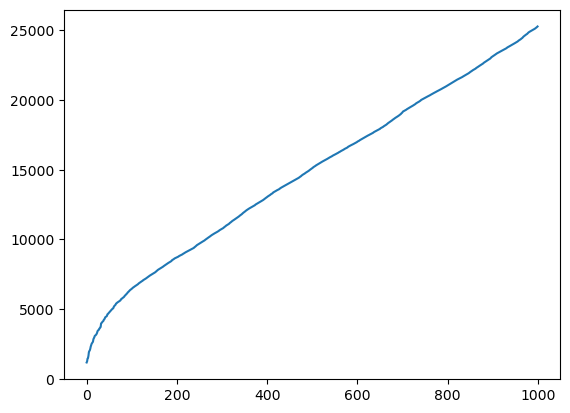

In [39]:
import matplotlib.pyplot as plt
logger.setLevel("ERROR")
plt.plot(timesteps)


In [40]:
values = np.max(agent._Q, axis=-1)
policy = np.argmax(agent._Q, axis=-1)
values, policy

(array([[-17.57709691, -17.45659849, -15.91119352, -17.05874081,
         -16.00126908, -13.65839295, -11.56440634,  -8.65931032,
          -7.32117995,  -7.62334437],
        [-19.00149835, -18.50829871, -16.5845048 , -14.16096562,
         -15.69957858, -13.31914276, -13.53638173, -10.92001154,
         -11.67914574,  -7.89320141],
        [-19.68487134, -18.41028601, -17.94146915, -17.08753081,
         -14.20301483, -14.72248331, -13.12812435, -10.7661063 ,
          -8.77121141,  -7.2946502 ],
        [-20.39304997, -16.62119663, -15.02046319, -14.10073917,
         -15.58098127, -13.80535195, -11.7267649 ,   0.        ,
          -9.04143671,  -6.53676525],
        [-19.25690124, -18.18050009, -17.2769653 , -16.43277025,
         -14.95828901, -13.27476725,   0.        ,  -1.        ,
          -1.        ,  -6.56386457],
        [-18.84123507, -17.78994772, -16.3906189 , -15.67514239,
         -13.91693772,   0.        ,   0.        ,  -2.0006944 ,
          -3.73490775,  -5.303

2024-11-28 14:04:14,952 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0xffff3eecf230>


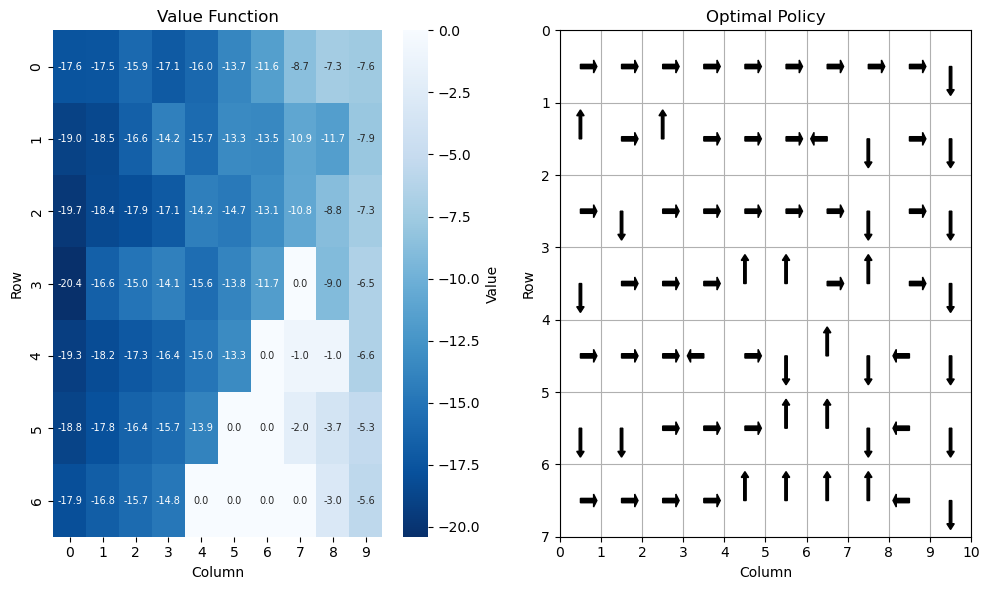

In [42]:
fig = visualize_gridworld(values, policy)

In [43]:
agent._Q[(3,0)]

array([-20.52384279, -20.78374386, -20.39304997, -21.02964444])

# King's Moves, Steady Wind

In [44]:
grid2 = Grid()
env2 = Environment(grid2)
agent2 = SarsaAgent(env2, 9)

In [45]:
logger.setLevel("ERROR")

timesteps2 = []
while len(timesteps2) < 1000:
    env2.reset()
    #agent2._e = 0
    time, ep = agent2.run_episode()
    timesteps2.append(time)


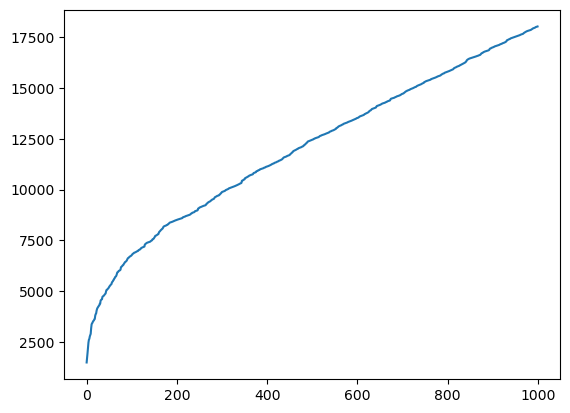

In [46]:
plt.plot(timesteps2)

In [47]:
values2 = np.max(agent2._Q, axis=-1)
policy2 = np.argmax(agent2._Q, axis=-1)
values2, policy2

(array([[-10.17739492, -10.23716684, -10.46919486, -10.81665137,
         -10.21308515,  -9.22939267,  -8.36846049,  -7.43677717,
          -6.27886783,  -5.09457741],
        [ -9.95423714, -10.1845836 , -10.02416199, -10.37986022,
          -9.97398829,  -8.99651522,  -8.0547612 ,  -7.13580496,
          -5.45035996,  -4.39101182],
        [ -9.31339551,  -9.48875758,  -9.41569703, -10.01253718,
          -9.4833997 ,  -8.85685095,  -8.14083935,  -6.21423681,
          -4.25885738,  -3.00427527],
        [ -8.55042235,  -9.71221322,  -7.47400559,  -9.93665692,
          -9.31564476,  -8.53923085,  -7.34348848,   0.        ,
          -1.        ,  -2.00036651],
        [ -9.48186797,  -7.66857865,  -6.76041169,  -7.17364876,
          -5.56227562,  -2.19861363,  -1.        ,  -0.99987793,
          -1.        ,  -1.65527344],
        [ -8.96975278,  -7.99298661,  -7.06988136,  -6.16944257,
          -4.30698733,  -3.13491517,  -1.        ,  -0.9375    ,
          -0.75      ,  -0.937

2024-11-28 14:04:17,479 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0xffff3f1a3aa0>


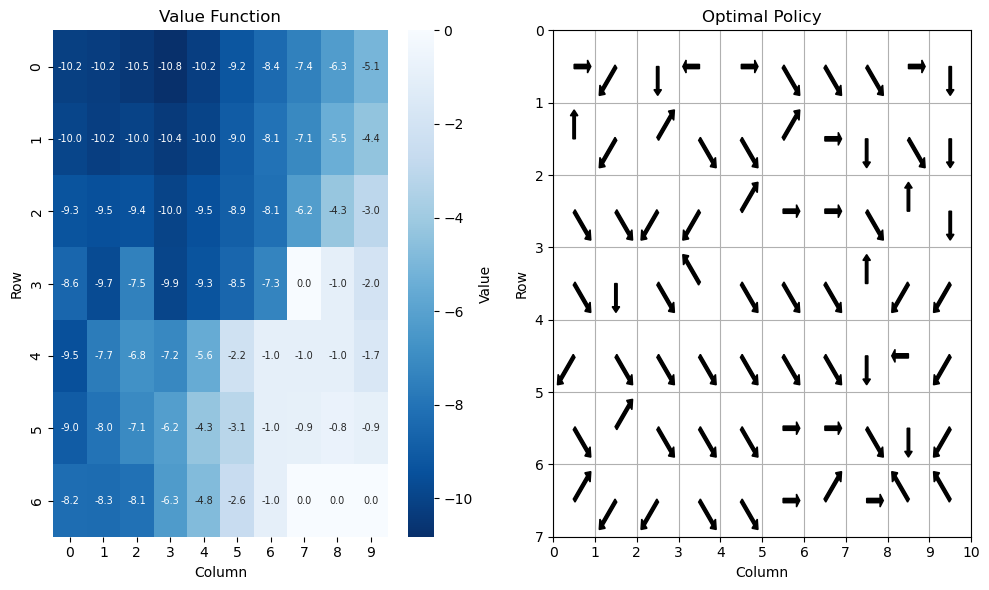

In [48]:
fig = visualize_gridworld(values2, policy2)

# King's Moves, Stochastic Wind

Wind can be the given wind +/-1.

In [12]:
grid3 = Grid(windType=WindType.STOCHASTIC)
env3 = Environment(grid3)
agent3 = SarsaAgent(env3, 9)

In [13]:
logger.setLevel("ERROR")

timesteps3 = []
while len(timesteps3) < 1000:
    env3.reset()
    time, ep = agent3.run_episode()
    timesteps3.append(time)

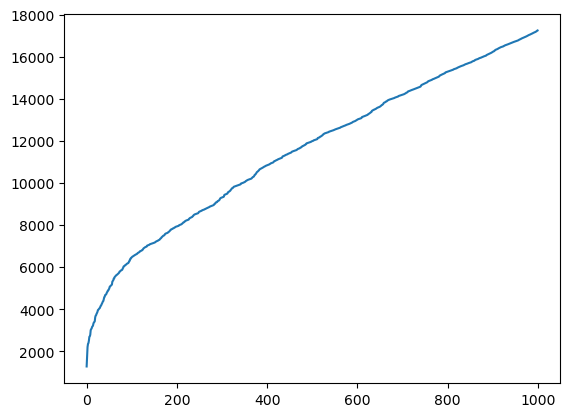

In [14]:
import matplotlib.pyplot as plt
plt.plot(timesteps3)

In [15]:
values3 = np.max(agent3._Q, axis=-1)
policy3 = np.argmax(agent3._Q, axis=-1)
values3, policy3

(array([[-10.05528445,  -9.91936484, -10.19767782, -10.24285424,
          -9.81478273,  -8.53456911,  -7.08777177,  -6.73367182,
          -5.34686728,  -4.03850189],
        [ -9.56691813,  -9.8522213 ,  -9.77273954,  -9.84419246,
          -9.4149134 ,  -8.68757927,  -7.32009058,  -6.57742404,
          -4.10533814,  -3.00175615],
        [ -9.6236381 ,  -8.88982988,  -9.39238363,  -9.91208031,
          -9.31884079,  -8.67169752,  -7.07695383,  -5.36338487,
          -4.6128689 ,  -2.00014634],
        [ -9.66344226,  -8.8522191 ,  -8.90371259,  -9.1125798 ,
          -8.94533214,  -8.10590661,  -6.82023925,   0.        ,
          -1.        ,  -2.        ],
        [ -8.97010518,  -8.5500577 ,  -6.70536842,  -5.77684016,
          -5.67411111,  -7.09940138,  -1.        ,  -0.99902344,
          -1.        ,  -1.28125   ],
        [ -7.75725681,  -7.86714555,  -7.98061669,  -4.45933269,
          -3.03664891,  -2.00335801,  -1.        ,  -0.96875   ,
          -0.5       ,  -0.75 

2024-11-28 14:07:44,769 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0xffff52291b80>


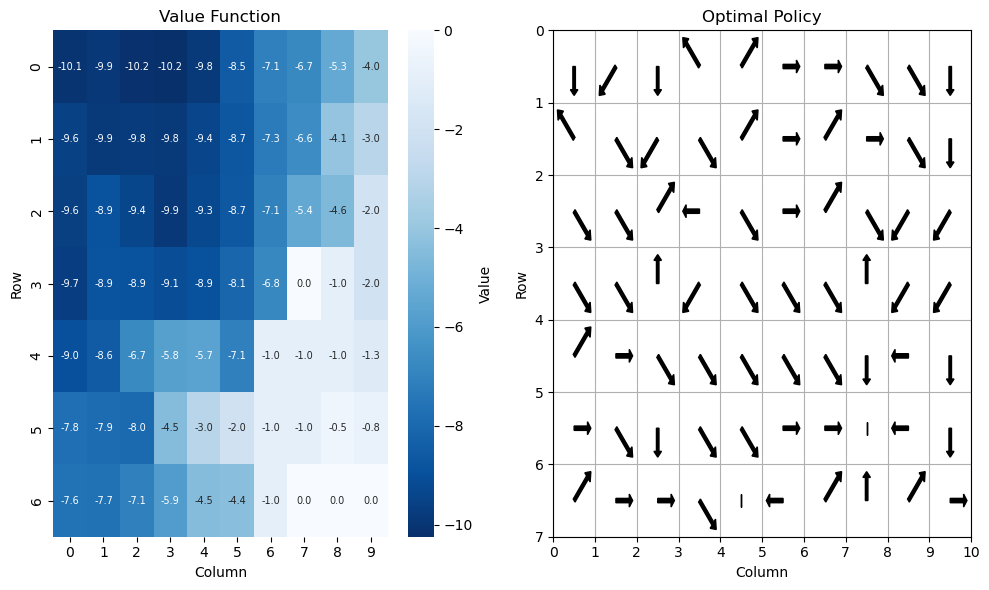

In [17]:
fig = visualize_gridworld(values3, policy3)